In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

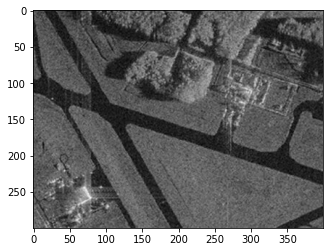

In [4]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

In [52]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
                                                            
    if abs(av_val - img[point]) <= T:
        return True
    
    return False
    

In [53]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask
        
    return mask*255
    

In [67]:
seed_point = (250,250)
mask = region_growing(image_gray,seed_point,homo_average,1, 10)

3
4
4
5
7
6
6
9
7
6
6
9
13
12
15
17
13
13
16
16
14
16
15
16
10
11
14
13
14
10
10
14
17
15
36
22
21
18
21
21
25
23
43
31
34
23
20
27
29
35
40
32
35
42
48
52
30
23
20
19
19
20
18
22
74
24
26
29
30
27
29
29
28
29
20
17
17
21
20
25
23
24
20
18
19
15
18
18
15
18
13
10
9
7
9
9
10
11
12
10
12
11
8
9
7
4
3
6
6
6
5
5
5
3
2
2
2
1
0


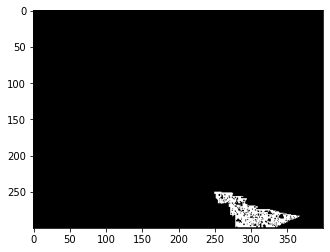

In [68]:
plt.imshow(mask, cmap="gray")

# K-means

In [7]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [8]:
flags = cv2.KMEANS_RANDOM_CENTERS

In [10]:
z = image_gray.reshape((-1,3))
# convert to np.float32
z = np.float32(z)
# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image_gray.shape))

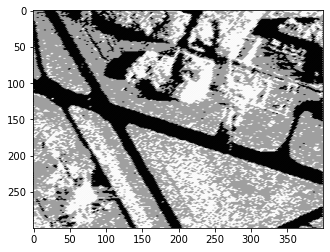

In [11]:
plt.imshow(res2, cmap="gray")

# Watershed+Distance transform

In [5]:
image = cv2.imread('oranges_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

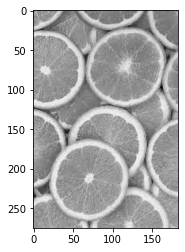

In [6]:
plt.imshow(image_gray, cmap="gray")

In [7]:
ret, thresh = cv2.threshold(image_gray,0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

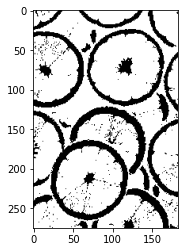

In [8]:
plt.imshow(thresh, cmap="gray")

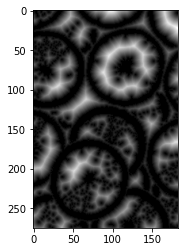

In [9]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist, cmap="gray")

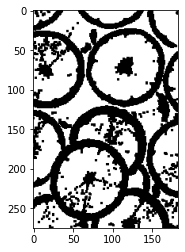

In [11]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY) 
plt.imshow(sure_fg, cmap="gray")

In [20]:
sure_fg = sure_fg.astype(np.uint8)

In [21]:
ret, markers = cv2.connectedComponents(sure_fg) 

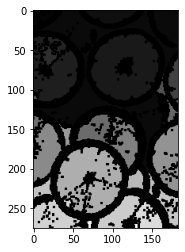

In [22]:
plt.imshow(markers, cmap="gray")

In [30]:
markers = cv2.watershed(image, markers)

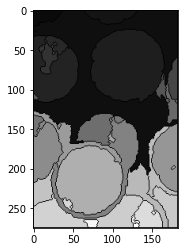

In [34]:
plt.imshow(markers, cmap="gray")

In [1]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [7]:
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [9]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [10]:
seed_point = (image_gray.shape[0] // 2, image_gray.shape[1] // 2)  # центр изображения
threshold = 25  
max_region_size = 500000

height, width = image_gray.shape
segmented = np.zeros_like(image_gray)
visited = np.zeros_like(image_gray)

stack = [seed_point]
seed_value = image_gray[seed_point]
region_size = 0

In [11]:
neighbors = [(-1, 0), (0, -1), (0, 1), (1, 0)]

In [12]:
while stack and region_size < max_region_size:
    x, y = stack.pop()
    
    if visited[x, y]:
        continue
        
    visited[x, y] = 1
    segmented[x, y] = 255
    region_size += 1
    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy
        
        if (0 <= nx < height and 0 <= ny < width and 
            not visited[nx, ny] and 
            abs(int(image_gray[x, y]) - int(image_gray[nx, ny])) < threshold and
            abs(int(seed_value) - int(image_gray[nx, ny])) < threshold * 2):  
            stack.append((nx, ny))

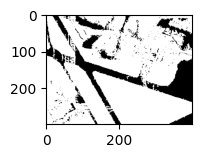

In [13]:
plt.subplot(1, 3, 3)
plt.imshow(segmented, cmap='gray')

In [14]:
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

In [15]:
# КРИТЕРИЙ НА ОСНОВЕ ГРАДИЕНТА

In [16]:
image_filtered = cv2.medianBlur(image_gray, 3)

In [17]:
height, width = image_filtered.shape
seed_point = (height // 2, width // 2)
gradient_threshold = 50  # Порог для величины градиента
max_region_size = 500000

In [18]:
grad_x = cv2.Sobel(image_filtered, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(image_filtered, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

In [19]:
gradient_normalized = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [20]:
segmented = np.zeros_like(image_filtered)
visited = np.zeros_like(image_filtered)

In [21]:
stack = [seed_point]
region_size = 0

In [22]:
neighbors = [(-1, -1), (-1, 0), (-1, 1),
             (0, -1),          (0, 1),
             (1, -1),  (1, 0),  (1, 1)]

In [23]:
while stack and region_size < max_region_size:
    x, y = stack.pop()
    if visited[x, y]:
        continue
    visited[x, y] = 1
    segmented[x, y] = 255
    region_size += 1

    for dx, dy in neighbors:
        nx, ny = x + dx, y + dy
        if (0 <= nx < height and 0 <= ny < width and 
            not visited[nx, ny]):
            if gradient_magnitude[nx, ny] < gradient_threshold:
                stack.append((nx, ny))

In [24]:
kernel = np.ones((3, 3), np.uint8)
segmented_processed = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, kernel)

In [25]:
plt.figure(figsize=(18, 6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

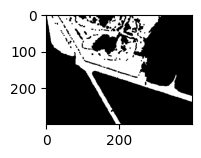

In [26]:
plt.subplot(2, 3, 4)
plt.imshow(segmented_processed, cmap='gray')

In [27]:
region_size_original = np.sum(segmented_processed > 0)
coverage_original = (region_size_original / (height * width)) * 100
print(f"Размер региона: {region_size_original} пикселей ({coverage_original:.2f}%)")

Размер региона: 35141 пикселей (29.28%)


In [28]:
region_size_original = np.sum(segmented > 0)
coverage_original = (region_size_original / (height * width)) * 100
print(f"Размер региона: {region_size_original} пикселей ({coverage_original:.2f}%)")

Размер региона: 30803 пикселей (25.67%)


In [29]:
region_pixels_original = image_filtered[segmented_processed > 0]
region_pixels_gradient = image_filtered[segmented > 0]

intensity_std_original = np.std(region_pixels_original) if len(region_pixels_original) > 0 else 0
intensity_std_gradient = np.std(region_pixels_gradient) if len(region_pixels_gradient) > 0 else 0

print(f"Стандартное отклонение интенсивности:")
print(f"  ОРИГИНАЛЬНЫЙ: {intensity_std_original:.2f}")
print(f"  ГРАДИЕНТ:    {intensity_std_gradient:.2f}")

if intensity_std_original < intensity_std_gradient:
    print("Оригинальный метод")
else:
    print("Метод градиента")

Стандартное отклонение интенсивности:
  ОРИГИНАЛЬНЫЙ: 25.33
  ГРАДИЕНТ:    25.49
Оригинальный метод


In [30]:
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [22]:
image_palms = cv2.imread('palm_1.JPG')
image_palms_gray = cv2.cvtColor(image_palms, cv2.COLOR_BGR2GRAY) 

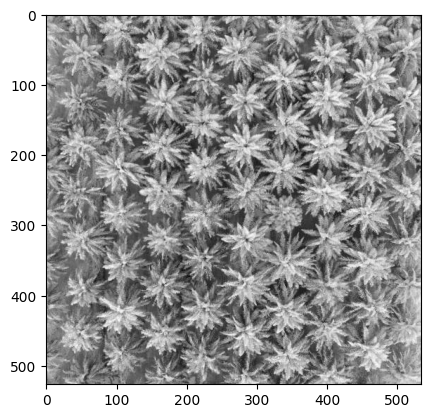

In [23]:
plt.imshow(image_palms_gray, cmap="gray")

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [59]:
# Загружаем изображение
image_palms = cv2.imread("palm_1.JPG")

In [60]:
# Преобразование в градации серого
image_palms_gray = cv2.cvtColor(image_palms, cv2.COLOR_BGR2GRAY)

In [61]:
# Размытие Гаусса
image_palms_blurred = cv2.GaussianBlur(image_palms_gray, (13, 13), 0)

In [62]:
# Пороговая бинаризация (Otsu + инверсия)
ret, thresh = cv2.threshold(image_palms_blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [63]:
# Морфологические операции для улучшения качества
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

In [64]:
# Определяем область фона
sure_bg = cv2.dilate(opening, kernel, iterations=3)

In [65]:
# Distance Transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

In [66]:
# Выделение точных объектов (центры деревьев)
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

In [67]:
# Неизвестная область
unknown = cv2.subtract(sure_bg, sure_fg)

In [68]:
# Создание маркеров для watershed
ret, markers = cv2.connectedComponents(sure_fg)

In [69]:
# Добавляем 1 ко всем меткам, чтобы фон был не 0, а 1
markers = markers + 1

In [70]:
# Помечаем неизвестную область как 0
markers[unknown == 255] = 0

In [71]:
# Алгоритм Watershed
markers_watershed = cv2.watershed(image_palms, markers)

In [72]:
num_palms = len(np.unique(markers_watershed)) - 1  # -1 для фона
print(f"\nРЕЗУЛЬТАТ: Количество найденных деревьев: {num_palms}")


РЕЗУЛЬТАТ: Количество найденных деревьев: 101


In [78]:
segmented_image = image_palms.copy()
segmented_image[markers_watershed == -1] = [255, 0, 0]

In [79]:
plt.figure(figsize=(25, 12))

<Figure size 2500x1200 with 0 Axes>

<Figure size 2500x1200 with 0 Axes>

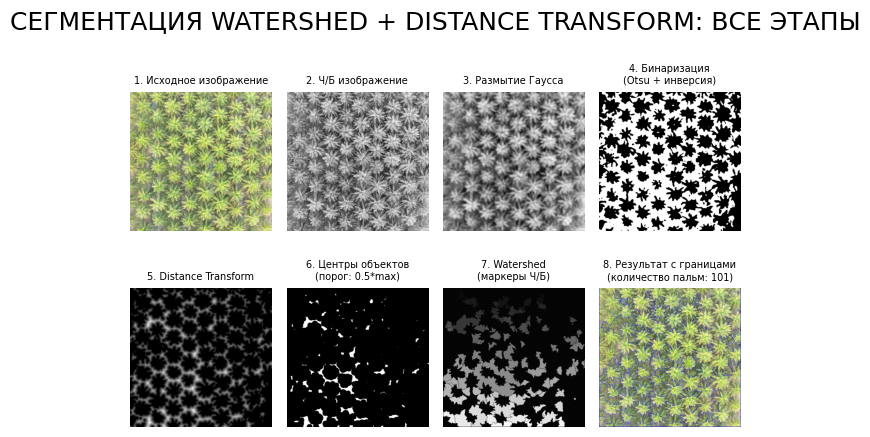

In [81]:
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image_palms, cv2.COLOR_BGR2RGB))
plt.title("1. Исходное изображение", fontsize=7)
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(image_palms_gray, cmap='gray')
plt.title("2. Ч/Б изображение", fontsize=7)
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(image_palms_blurred, cmap='gray')
plt.title("3. Размытие Гаусса", fontsize=7)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(thresh, cmap='gray')
plt.title("4. Бинаризация\n(Otsu + инверсия)", fontsize=7)
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(dist_transform, cmap='gray')
plt.title("5. Distance Transform", fontsize=7) 
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(sure_fg, cmap='gray')
plt.title("6. Центры объектов\n(порог: 0.5*max)", fontsize=7)
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(markers_watershed, cmap='gray')
plt.title("7. Watershed\n(маркеры Ч/Б)", fontsize=7)
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.title(f'8. Результат с границами\n', fontsize=7)
plt.axis('off')

plt.suptitle("СЕГМЕНТАЦИЯ", fontsize=18)
plt.tight_layout()
plt.show()